In [1]:
# Dependencies
import requests
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
import openpyxl
import time
from scipy import stats
from pathlib import Path

In [2]:
## Read in Files
hpi_inc_comb = pd.read_csv('Input_Files/medsp_medinc_casesch.csv')
deflator = pd.read_csv('Input_Files/cpi_data.csv')
deflator_dj = deflator.copy()
dj = pd.read_csv('Input_Files/dowjones_mth.csv')

### Median Income and Median House Sales Price

In [3]:
hpi_inc_comb = hpi_inc_comb.rename(columns = {'MEHOINUSA646N_NBD19870101':'Median Household Income Index',
                                              'MEHOINUSA646N':'Median Household Income',
                                              'CSUSHPINSA_NBD19870101':'Case Schiller Index',
                                             'MSPUS_NBD19870101':'Median Home Sale Price Index'})

In [4]:
hpi_inc_comb.drop(hpi_inc_comb[hpi_inc_comb['DATE'] == '2022-01-01'].index, inplace=True)
hpi_inc_comb['DATE'] = hpi_inc_comb['DATE'].astype('datetime64[D]')
hpi_inc_comb['Median Household Income Index'] = hpi_inc_comb['Median Household Income Index'].astype(float)
hpi_inc_comb['Median Household Income'] = hpi_inc_comb['Median Household Income'].astype(float)
hpi_inc_comb.head()

,DATE,Median Household Income Index,Median Household Income,Case Schiller Index,Median Home Sale Price Index
0,1987-01-01,100.00000,26061.0,100.00000,100.00000
1,1988-01-01,104.46644,27225.0,107.37059,107.18720
2,1989-01-01,110.91670,28906.0,113.96065,115.01910
3,1990-01-01,114.89582,29943.0,116.12178,116.80993
4,1991-01-01,115.59802,30126.0,114.59039,114.58930


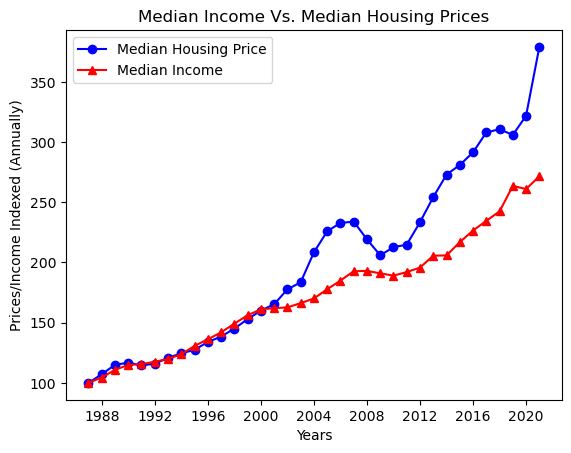

In [5]:
x_axis = hpi_inc_comb['DATE']
med = hpi_inc_comb['Median Household Income Index']
hpi = hpi_inc_comb['Median Home Sale Price Index']
plt.show()
hpi_handle, = plt.plot(x_axis, hpi, marker ='o', color='blue', label="Median Housing Price")
med_handle, = plt.plot(x_axis, med, marker='^', color='red', label="Median Income")
plt.title("Median Income Vs. Median Housing Prices")
plt.xlabel("Years")
plt.ylabel("Prices/Income Indexed (Annually)")
plt.legend(handles=[hpi_handle, med_handle], loc="best")
plt.savefig('Images/Med_Inc_Med_HPI.jpg')
plt.show()

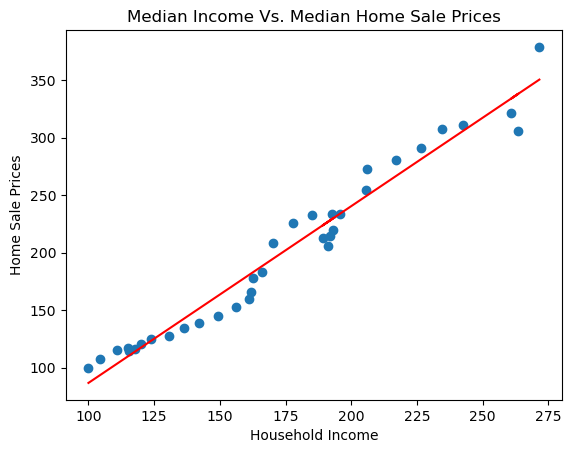

In [6]:
correlation = st.pearsonr(hpi_inc_comb['Median Household Income Index'],hpi_inc_comb['Median Home Sale Price Index'])
plt.scatter(hpi_inc_comb['Median Household Income Index'],hpi_inc_comb['Median Home Sale Price Index'])
plt.xlabel('Household Income')
plt.ylabel('Home Sale Prices')
plt.title("Median Income Vs. Median Home Sale Prices")
(slope, intercept, rvalue, pvalue, stderr) = linregress(hpi_inc_comb['Median Household Income Index'],hpi_inc_comb['Median Home Sale Price Index'])
regress_values = hpi_inc_comb['Median Household Income Index'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(hpi_inc_comb['Median Household Income Index'],regress_values,"r-")
plt.savefig('Images/reg_hpi_inc.png')
plt.show()

In [7]:
correlation

PearsonRResult(statistic=0.9811834941440882, pvalue=3.7697690153741353e-25)

### CPI Deflator

In [8]:
deflator['Year'] =  pd.to_datetime(deflator['Year'], format='%Y')
deflator.rename(columns = {'Annual':'CPI', 'Year':'DATE'}, inplace = True)
deflated_inc = hpi_inc_comb.merge(deflator, on = 'DATE',how = 'left')
deflated_inc.head()

,DATE,Median Household Income Index,Median Household Income,Case Schiller Index,Median Home Sale Price Index,CPI
0,1987-01-01,100.00000,26061.0,100.00000,100.00000,113.6
1,1988-01-01,104.46644,27225.0,107.37059,107.18720,118.3
2,1989-01-01,110.91670,28906.0,113.96065,115.01910,124.0
3,1990-01-01,114.89582,29943.0,116.12178,116.80993,130.7
4,1991-01-01,115.59802,30126.0,114.59039,114.58930,136.2


In [9]:
deflated_inc['CPI_deflator'] = (((deflated_inc['CPI']/ deflated_inc['CPI'][0])-1)*100)+100
# deflated_inc['CPI_deflator'] = deflated_inc['CPI'].pct_change(periods = 1)+1
# deflated_inc.loc[0,'CPI_deflator'] = 1
deflated_inc.head()
deflated_inc['Median Home Sale Price Index_deflated'] = deflated_inc['Median Home Sale Price Index'] / deflated_inc['CPI_deflator']
deflated_inc['Median Household Income Index_deflated'] = deflated_inc['Median Household Income Index'] / deflated_inc['CPI_deflator']

In [10]:
deflated_inc.head()

,DATE,Median Household Income Index,Median Household Income,Case Schiller Index,Median Home Sale Price Index,CPI,CPI_deflator,Median Home Sale Price Index_deflated,Median Household Income Index_deflated
0,1987-01-01,100.00000,26061.0,100.00000,100.00000,113.6,100.000000,1.000000,1.000000
1,1988-01-01,104.46644,27225.0,107.37059,107.18720,118.3,104.137324,1.029287,1.003160
2,1989-01-01,110.91670,28906.0,113.96065,115.01910,124.0,109.154930,1.053723,1.016140
3,1990-01-01,114.89582,29943.0,116.12178,116.80993,130.7,115.052817,1.015272,0.998635
4,1991-01-01,115.59802,30126.0,114.59039,114.58930,136.2,119.894366,0.955752,0.964166


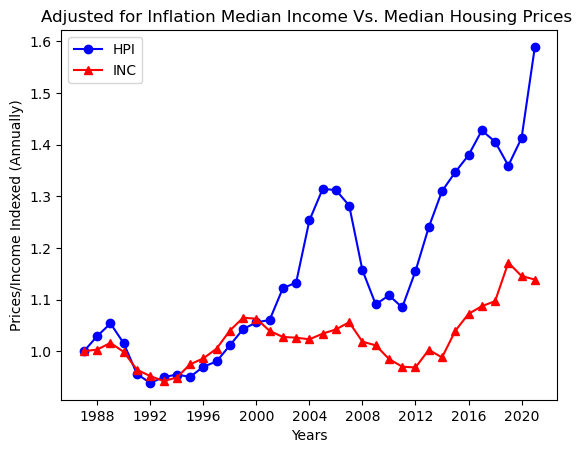

In [11]:
x_axis = deflated_inc['DATE']
hpi = deflated_inc['Median Home Sale Price Index_deflated']
med = deflated_inc['Median Household Income Index_deflated']
plt.show()
hpi_handle, = plt.plot(x_axis, hpi, marker ='o', color='blue', label="HPI")
# Each point on the cosine chart is marked by a red triangle
med_handle, = plt.plot(x_axis, med, marker='^', color='red', label="INC")

plt.title("Adjusted for Inflation Median Income Vs. Median Housing Prices ")
plt.xlabel("Years")
plt.ylabel("Prices/Income Indexed (Annually)")
plt.legend(handles=[hpi_handle, med_handle], loc="best")
plt.savefig('Images/inflationadj_hpi_inc.png')
plt.show()

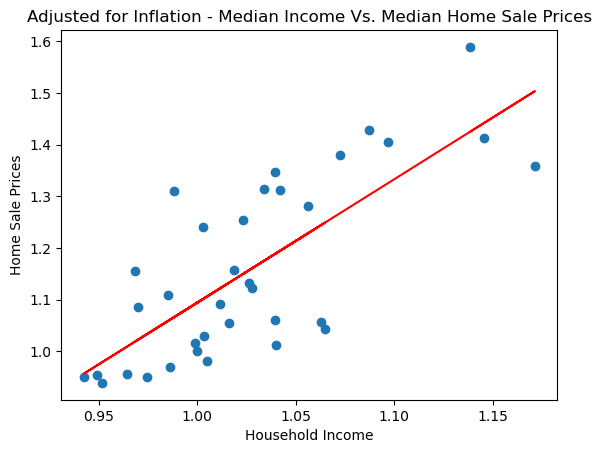

In [12]:
correlation = st.pearsonr(deflated_inc['Median Household Income Index_deflated'],deflated_inc['Median Home Sale Price Index_deflated'])
plt.scatter(deflated_inc['Median Household Income Index_deflated'],deflated_inc['Median Home Sale Price Index_deflated'])
plt.xlabel('Household Income')
plt.ylabel('Home Sale Prices')
plt.title("Adjusted for Inflation - Median Income Vs. Median Home Sale Prices")
(slope, intercept, rvalue, pvalue, stderr) = linregress(deflated_inc['Median Household Income Index_deflated'],deflated_inc['Median Home Sale Price Index_deflated'])
regress_values = deflated_inc['Median Household Income Index_deflated'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(deflated_inc['Median Household Income Index_deflated'],regress_values,"r-")
plt.savefig('Images/inflationadj_hpi_inc_reg.png')
plt.show()

In [13]:
correlation

PearsonRResult(statistic=0.7522583744568648, pvalue=1.880644151374282e-07)

### Dow Jones vs Housing Prices

In [14]:
dj.sort_values('Date').head()
dj['Adj Close**'] =dj['Adj Close**'].map(lambda x: float(x.replace(",", "")))
dj['Date'] = dj['Date'].astype('datetime64[D]')
dj['Adj Close**'] = dj['Adj Close**'].astype(float)
dj['year'] = pd.DatetimeIndex(dj['Date']).year
dj1 =dj.groupby('year')[['Adj Close**']].mean().reset_index()
dj1['year'] = dj1['year'].astype(int)

In [15]:
hpi_inc_comb['year'] = pd.DatetimeIndex(hpi_inc_comb['DATE']).year
djnew = dj1.merge(hpi_inc_comb[['year','Median Home Sale Price Index']], on = 'year', how = 'left')
djnew['DJ Index'] = (((djnew['Adj Close**']/ djnew['Adj Close**'][0])-1)*100)+100
djnew['Median Sales Price Index'] = (((djnew['Median Home Sale Price Index']/ djnew['Median Home Sale Price Index'][0])-1)*100)+100
djnew.dropna(inplace = True)
djnew.head()

,year,Adj Close**,Median Home Sale Price Index,DJ Index,Median Sales Price Index
0,1992,3303.019091,115.92646,100.000000,100.000000
1,1993,3537.620833,120.82139,107.102646,104.222444
2,1994,3792.855000,124.57020,114.829945,107.456227
3,1995,4534.192500,127.48329,137.274184,109.969105
4,1996,5780.132500,133.95415,174.995431,115.550971


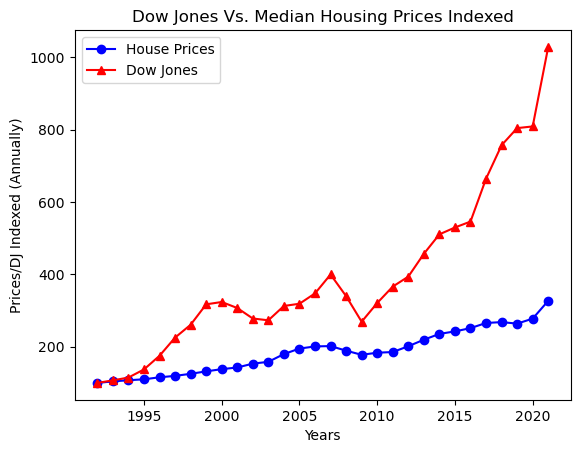

In [16]:
x_axis = djnew['year']
dj = djnew['Median Sales Price Index']
med = djnew['DJ Index']
plt.show()
hpi_handle, = plt.plot(x_axis, dj, marker ='o', color='blue', label="House Prices")

med_handle, = plt.plot(x_axis, med, marker='^', color='red', label="Dow Jones")
plt.title("Dow Jones Vs. Median Housing Prices Indexed")
plt.xlabel("Years")
plt.ylabel("Prices/DJ Indexed (Annually)")
plt.legend(handles=[hpi_handle, med_handle], loc="best")
plt.savefig('Images/indexed_dj_hpi.png')
plt.show()

In [17]:
djnew['log_dif_dj'] = np.log(djnew['DJ Index']).diff()
djnew['log_dif_hp'] = np.log(djnew['Median Sales Price Index']).diff()

In [18]:
djnew.dropna(inplace=True)

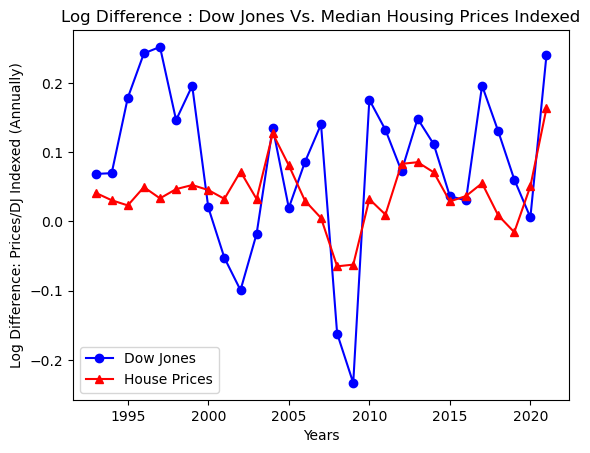

In [19]:
x_axis = djnew['year']
dj = djnew['log_dif_dj']
med = djnew['log_dif_hp']
plt.show()
hpi_handle, = plt.plot(x_axis, dj, marker ='o', color='blue', label="Dow Jones")
plt.title("Log Difference : Dow Jones Vs. Median Housing Prices Indexed")
plt.xlabel("Years")
plt.ylabel("Log Difference: Prices/DJ Indexed (Annually)")
med_handle, = plt.plot(x_axis, med, marker='^', color='red', label="House Prices")
plt.legend(handles=[hpi_handle, med_handle], loc="best")
plt.savefig('Images/log_difference_income_hpi.png')
plt.show()

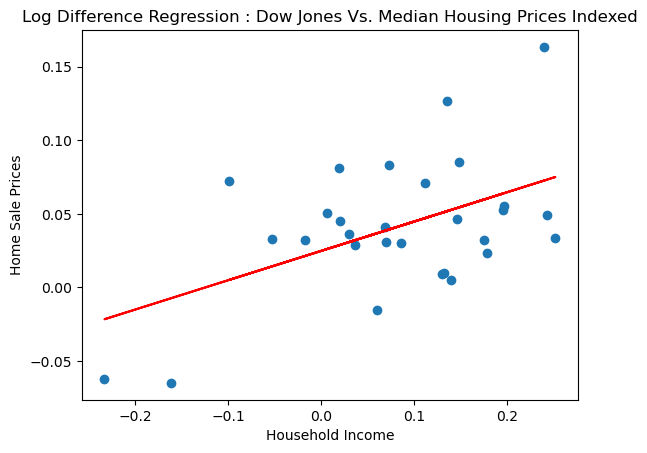

In [20]:
correlation = st.pearsonr(djnew['log_dif_dj'],djnew['log_dif_hp'])
plt.scatter(djnew['log_dif_dj'],djnew['log_dif_hp'])
plt.xlabel('Household Income')
plt.ylabel('Home Sale Prices')
plt.title("Log Difference Regression : Dow Jones Vs. Median Housing Prices Indexed")
(slope, intercept, rvalue, pvalue, stderr) = linregress(djnew['log_dif_dj'],djnew['log_dif_hp'])
regress_values = djnew['log_dif_dj'] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(djnew['log_dif_dj'],regress_values,"r-")
plt.savefig('Images/log_regression_hpi_inc.png')
plt.show()

In [21]:
correlation

PearsonRResult(statistic=0.50532856136497, pvalue=0.0051713010040318275)

### Break

In [22]:
#loading the Excel files
houseprice = "Input_Files/Median Sales Price of Houses Sold for the United States.xls"
rentocc = "Input_Files/Housing Inventory Estimate Renter Occupied Housing Units in the United States.xls"
rentindex = "Input_Files/CPI_RENT_INDEX.xls"
#reading in the Excel files
houseprices = pd.read_excel(houseprice)
rentoccs = pd.read_excel(rentocc)
rentindec = pd.read_excel(rentindex)

In [23]:
#Combining datasets
rentandhouse = rentoccs.merge(houseprices, on='observation_date', how='left')

In [24]:
#one more combine
rentsandhouse = rentandhouse.merge(rentindec, on='observation_date', how='left')

In [25]:
#Rename the columns
rentsandhouse.rename(columns = {'ERNTOCCUSQ176N' : 'rental_occupancy', 'MSPUS' : 'median_house_sale', 'CUUR0000SEHA_NBD20000401' : 'qrt_rent_ind'} , inplace = True)

In [26]:
#Make a CSV
rentsandhouse.info()
rentsandhouse.to_csv("Input_Files/LPhouseandrent.csv", index_label="")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 92
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   observation_date   93 non-null     datetime64[ns]
 1   rental_occupancy   93 non-null     int64         
 2   median_house_sale  93 non-null     int64         
 3   qrt_rent_ind       93 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.6 KB


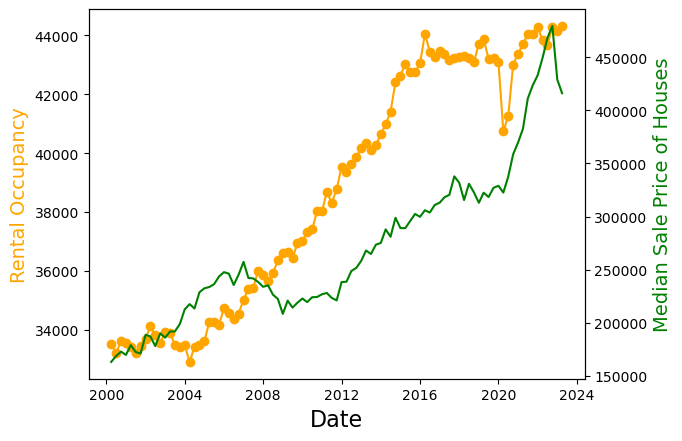

In [27]:
#First Chart
fig,ax = plt.subplots()
ax.plot(rentsandhouse["observation_date"], rentsandhouse["rental_occupancy"], color="orange", marker="o")
ax.set_xlabel("Date", fontsize = 16)
ax.set_ylabel("Rental Occupancy", color="orange", fontsize = 14)
ax2 = ax.twinx()
ax2.plot(rentsandhouse["observation_date"], rentsandhouse["median_house_sale"], color="green")
ax2.set_ylabel("Median Sale Price of Houses", color="green", fontsize = 14)
#plt.plot(rentsandhouse["observation_date"], oh_fit, "--")
plt.savefig("Images/RentoccVshouse.png")
plt.show()

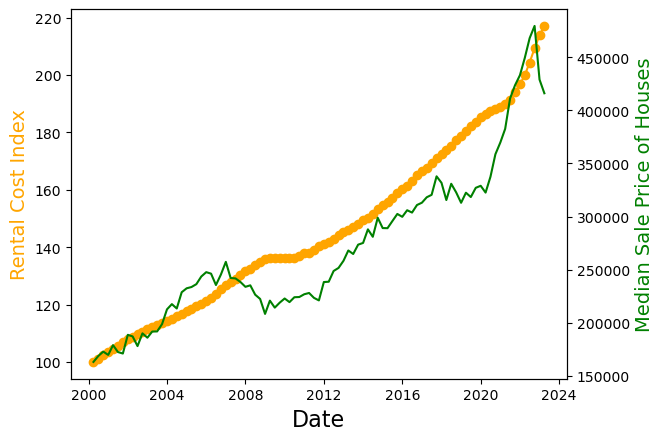

In [28]:
#second chart
fig,ax = plt.subplots()
ax.plot(rentsandhouse["observation_date"], rentsandhouse["qrt_rent_ind"], color="orange", marker="o")
ax.set_xlabel("Date", fontsize = 16)
ax.set_ylabel("Rental Cost Index", color="orange", fontsize = 14)
ax2 = ax.twinx()
ax2.plot(rentsandhouse["observation_date"], rentsandhouse["median_house_sale"], color="green")
ax2.set_ylabel("Median Sale Price of Houses", color="green", fontsize = 14)
plt.savefig("Images/RentIndVshouse.png")
plt.show()

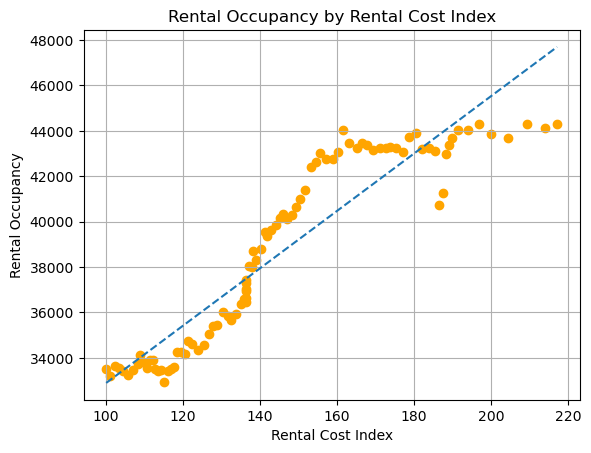

In [29]:
#third chart (maybe)
rentalocc = rentsandhouse["rental_occupancy"]
rentindx = rentsandhouse["qrt_rent_ind"] 

re_slope, re_int, re_r, re_p, re_std_err = stats.linregress(rentindx, rentalocc)

re_fit = re_slope * rentindx + re_int

plt.scatter(rentsandhouse["qrt_rent_ind"], rentsandhouse["rental_occupancy"], marker="o", color="orange")
plt.plot(rentindx, re_fit, "--")
# Incorporate the other graph properties
plt.title("Rental Occupancy by Rental Cost Index")
plt.ylabel("Rental Occupancy")
plt.xlabel("Rental Cost Index")
plt.grid(True)

# Save the figure
plt.savefig("Images/rentoccVsRentindx.png")

# Show plot
plt.show()

### Break

In [30]:
TCSR_an_path = "Input_Files/Tot Constr Spend Resi Annual index2002.csv"
NHSP_an_path = "Input_Files/Median Sales Price for New Houses Sold Annual index2002.csv"
HSP_an_path = "Input_Files/Median Sales Price of Houses Sold Annual index2002.csv"

In [31]:
data1 = pd.read_csv(TCSR_an_path)
Ta_data_df = pd.DataFrame(data1)
data2 = pd.read_csv(NHSP_an_path)
NHa_data_df = pd.DataFrame(data2)
data3 = pd.read_csv(HSP_an_path)
Ha_data_df = pd.DataFrame(data3)
NHa_data_df['DATE'] = NHa_data_df['DATE'].astype('datetime64[D]')
Ta_data_df['DATE'] = Ta_data_df['DATE'].astype('datetime64[D]')
Ha_data_df['DATE'] = Ha_data_df['DATE'].astype('datetime64[D]')

In [32]:
merge1 = pd.merge(Ta_data_df, NHa_data_df, how="left", on=["DATE"])
merge1_df = pd.DataFrame(merge1)
merge1_df.head()

,DATE,TLRESCONS_NBD20020101,MSPNHS
0,2002-01-01,100.00000,100
1,2003-01-01,112.18848,103.43647
2,2004-01-01,133.78736,117.72283
3,2005-01-01,156.69656,126.58199
4,2006-01-01,153.80531,131.36963


In [33]:
TCSR_NHSP_HSP_Pop = pd.merge(merge1_df, Ha_data_df, how="left", on=["DATE"])
final_comb_df = pd.DataFrame(TCSR_NHSP_HSP_Pop)
final_comb_df.dropna(inplace=True)
final_comb_df

,DATE,TLRESCONS_NBD20020101,MSPNHS,MSPNHSUS_NBD20020101
0,2002-01-01,100.00000,100,100.00000
1,2003-01-01,112.18848,103.43647,103.43647
2,2004-01-01,133.78736,117.72283,117.72283
3,2005-01-01,156.69656,126.58199,126.58199
4,2006-01-01,153.80531,131.36963,131.36963
5,2007-01-01,123.88044,131.73445,131.73445
6,2008-01-01,91.44695,124.52822,124.52822
7,2009-01-01,65.13301,115.93028,115.93028
8,2010-01-01,63.92207,119.57393,119.57393
9,2011-01-01,63.59139,121.23587,121.23587


In [34]:
final_comb_df.dtypes

DATE                     datetime64[ns]
TLRESCONS_NBD20020101            object
MSPNHS                           object
MSPNHSUS_NBD20020101            float64
dtype: object

In [35]:
final_comb_df['TLRESCONS_NBD20020101'] = final_comb_df['TLRESCONS_NBD20020101'].astype(float)
final_comb_df['MSPNHS'] = final_comb_df['MSPNHS'].astype(float)
final_comb_df.info()
final_comb_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 20
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DATE                   21 non-null     datetime64[ns]
 1   TLRESCONS_NBD20020101  21 non-null     float64       
 2   MSPNHS                 21 non-null     float64       
 3   MSPNHSUS_NBD20020101   21 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 840.0 bytes


,DATE,TLRESCONS_NBD20020101,MSPNHS,MSPNHSUS_NBD20020101
0,2002-01-01,100.00000,100.00000,100.00000
1,2003-01-01,112.18848,103.43647,103.43647
2,2004-01-01,133.78736,117.72283,117.72283
3,2005-01-01,156.69656,126.58199,126.58199
4,2006-01-01,153.80531,131.36963,131.36963
5,2007-01-01,123.88044,131.73445,131.73445
6,2008-01-01,91.44695,124.52822,124.52822
7,2009-01-01,65.13301,115.93028,115.93028
8,2010-01-01,63.92207,119.57393,119.57393
9,2011-01-01,63.59139,121.23587,121.23587


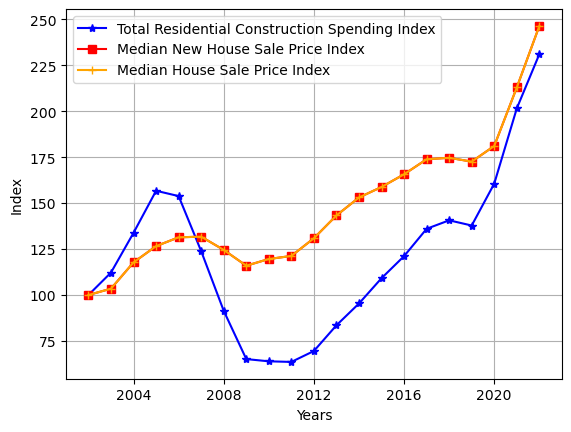

In [36]:
#all data plot
date = final_comb_df['DATE']
TCSR = final_comb_df['TLRESCONS_NBD20020101']
NHSP = final_comb_df["MSPNHS"]
HSP = final_comb_df['MSPNHSUS_NBD20020101']

TCSR = plt.plot(date, TCSR, marker="*",color="blue", label="Total Residential Construction Spending Index")
NHSP = plt.plot(date, NHSP, marker="s", color="Red", label="Median New House Sale Price Index")
HSP = plt.plot(date, HSP, marker="+",color="orange", label="Median House Sale Price Index")
plt.legend(loc="best")

plt.ylabel("Index")
plt.xlabel("Years")

plt.grid()
NC_1 = plt.gcf()
plt.show()
NC_1.savefig("Images/NC_Annual1.png")

Ttest_indResult(statistic=-2.0973382311706583, pvalue=0.042556241093287796)


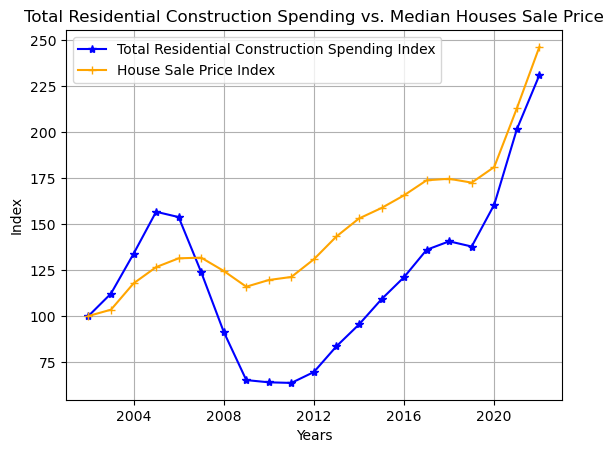

In [37]:
# Total Residential Construction Spending Index vs Median Houses Sale Price Index
date = final_comb_df['DATE']
x = final_comb_df['TLRESCONS_NBD20020101']
#NHSP = final_comb_df["MSPNHS"]
y = final_comb_df['MSPNHSUS_NBD20020101']

TCSR, = plt.plot(date, x, marker="*",color="blue", label="Total Residential Construction Spending Index")
#NHSP, = plt.plot(date, NHSP, marker="s", color="Red", label="NHSP")
HSP = plt.plot(date, y, marker="+",color="orange", label="House Sale Price Index")

plt.title("Total Residential Construction Spending vs. Median Houses Sale Price")
plt.ylabel("Index")
plt.xlabel("Years")

ttest = stats.ttest_ind(x, y, equal_var=False)
print(ttest)

plt.legend(loc="best")
plt.grid()
NC_2 = plt.gcf()
plt.show()
NC_2.savefig("Images/NC_Annual2.png")

### Break

In [38]:
mortgage_path = "Input_Files/Mortgage_Rates-Annual.csv"
all_houses_path = "Input_Files/All_House_Sale_Price-Annual.csv"
income_path = "Input_Files/Median_Household_Income-Annual.csv"

mortgage_data = pd.read_csv(mortgage_path)
all_houses = pd.read_csv(all_houses_path)
income = pd.read_csv(income_path)

In [39]:
mortgage_data.head()
all_houses.head()
income.head()

,DATE,MEHOINUSA672N
0,1984-01-01,55828
1,1985-01-01,56871
2,1986-01-01,58920
3,1987-01-01,59624
4,1988-01-01,60115


In [40]:
merge_data = pd.merge(pd.merge(all_houses, mortgage_data, on="DATE"),income,on="DATE")
merge_data.head()

,DATE,MSPUS,MORTGAGE30US,MEHOINUSA672N
0,1984-01-01,78200.0,13.8776923076923077,55828
1,1985-01-01,82800.0,12.4301923076923077,56871
2,1986-01-01,88000.0,10.1873076923076923,58920
3,1987-01-01,97900.0,10.2133962264150943,59624
4,1988-01-01,110000.0,10.3417307692307692,60115


In [41]:
merge_data = merge_data.rename(columns={"DATE" : "Date" , "MSPUS" : "Median Home Sale Price" , "MORTGAGE30US" : "Mortgage Rate", "MEHOINUSA672N" : "Median Household Income"}) 
merge_data.head()

,Date,Median Home Sale Price,Mortgage Rate,Median Household Income
0,1984-01-01,78200.0,13.8776923076923077,55828
1,1985-01-01,82800.0,12.4301923076923077,56871
2,1986-01-01,88000.0,10.1873076923076923,58920
3,1987-01-01,97900.0,10.2133962264150943,59624
4,1988-01-01,110000.0,10.3417307692307692,60115


In [42]:
merge_data['Date'] = merge_data['Date'].astype('datetime64[D]')
merge_data['Median Household Income'] = merge_data['Median Household Income'].astype(float)
merge_data['Mortgage Rate'] = merge_data['Mortgage Rate'].astype(float)
merge_data['Mortgage Rate'] = merge_data['Mortgage Rate'].round(2)
merge_data.tail()

,Date,Median Home Sale Price,Mortgage Rate,Median Household Income
33,2017-01-01,313100.0,3.99,67571.0
34,2018-01-01,331800.0,4.54,68168.0
35,2019-01-01,313000.0,3.94,72808.0
36,2020-01-01,329000.0,3.11,71186.0
37,2021-01-01,369800.0,2.96,70784.0


In [43]:
time = merge_data["Date"]
home_price = merge_data["Median Home Sale Price"]
income_data = merge_data["Median Household Income"]
mortgage_data = merge_data["Mortgage Rate"]

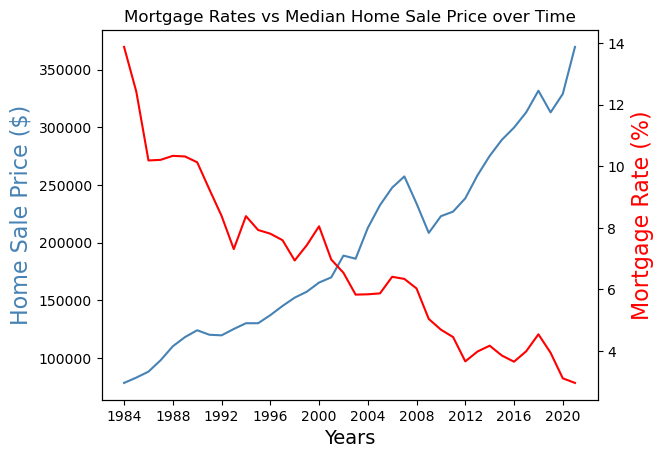

In [44]:

#define colors to use
col1 = 'steelblue'
col2 = 'red'

#define subplots
fig,ax = plt.subplots()

#add first line to plot
ax.plot(time, home_price, color=col1)

#add x-axis label
ax.set_xlabel('Years', fontsize=14)

#add y-axis label
ax.set_ylabel('Home Sale Price ($)', color=col1, fontsize=16)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

#add second line to plot
ax2.plot(time, mortgage_data, color=col2)

#add second y-axis label
ax2.set_ylabel('Mortgage Rate (%)', color=col2, fontsize=16)
plt.title('Mortgage Rates vs Median Home Sale Price over Time')
plt.savefig("Images/Mortgage Rate($).png")
plt.show()


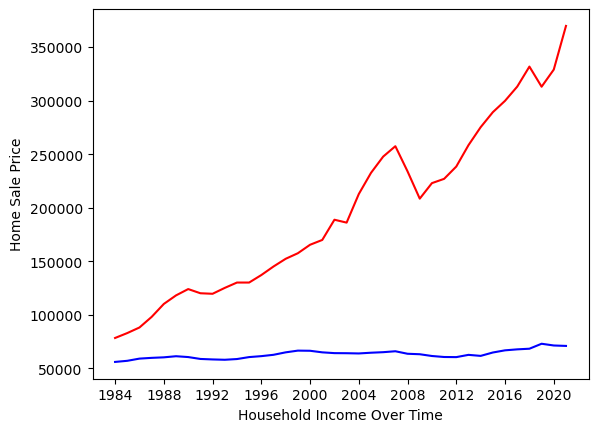

In [45]:
homes, = plt.plot(time, home_price, color="red", label="Median Home Sales Price")
income, = plt.plot(time, income_data, color="blue", label="Median Household Income")
plt.xlabel('Household Income Over Time')
plt.ylabel('Home Sale Price')
plt.savefig("Images/Household Income($).png")
plt.show()

Analysis: Home Prices have continued to go up over time whereas Household Income is relatvely flat.  

### Break

In [46]:
inflation_path = Path("Input_Files/InflationIndexAnnual.csv")
Median_Income_path = Path("Input_Files/MedianIncomeIndexAnnual.csv")
Median_Home_Price_path = Path("Input_Files/HomeSaleIndexAnnual.csv")
MedianIncomeDollars = Path("Input_Files/MedianIncomeDollars.csv")
MedianHomeDollars = Path("Input_Files/MedianHomeSalesDollars.csv")

In [47]:
inflation = pd.read_csv(inflation_path)
Median_Income = pd.read_csv(Median_Income_path)
Median_Home_Price = pd.read_csv(Median_Home_Price_path)
Median_Income_Dollars = pd.read_csv(MedianIncomeDollars)
Median_HomeSales_Dollars = pd.read_csv(MedianHomeDollars)

In [48]:
inflation.head()

,DATE,FPCPITOTLZGUSA_NBD19840101
0,1960-01-01,33.90220
1,1961-01-01,24.89746
2,1962-01-01,27.87498
3,1963-01-01,28.82593
4,1964-01-01,29.73843


In [49]:
Median_Income.head()

,DATE,MEHOINUSA646N_NBD19840101
0,1984-01-01,100.00000
1,1985-01-01,105.36694
2,1986-01-01,111.07294
3,1987-01-01,116.26589
4,1988-01-01,121.45884


In [50]:
Median_Home_Price.head()

,DATE,MSPUS_NBD19840101
0,1963-01-01,22.57661
1,1964-01-01,23.67104
2,1965-01-01,25.17198
3,1966-01-01,26.89181
4,1967-01-01,28.45528


In [51]:
Median_Income_Dollars = Median_Income_Dollars.rename(columns = {"MEHOINUSA646N": "Median Income in Dollars"})
Median_Income_Dollars.head()

,DATE,Median Income in Dollars
0,1984-01-01,22415
1,1985-01-01,23618
2,1986-01-01,24897
3,1987-01-01,26061
4,1988-01-01,27225


In [52]:
data_type_dict1 = {"DATE": "datetime64", "Median Income in Dollars": "int64"} 
Median_Income_Dollars = Median_Income_Dollars.astype(data_type_dict1)
Median_Income_Dollars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      38 non-null     datetime64[ns]
 1   Median Income in Dollars  38 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 736.0 bytes


In [53]:
Median_HomeSales_Dollars = Median_HomeSales_Dollars.loc[Median_HomeSales_Dollars["DATE"] < "2022-01-02"]
Median_HomeSales_Dollars.tail()

,DATE,MSPUS
55,2018-01-01,325275.000000000000
56,2019-01-01,320250.000000000000
57,2020-01-01,336950.000000000000
58,2021-01-01,396800.000000000000
59,2022-01-01,457475.000000000000


In [54]:
data_type_dict0 = {"DATE": "datetime64", "MSPUS": "float"} 
Median_HomeSales_Dollars = Median_HomeSales_Dollars.astype(data_type_dict0)
Median_HomeSales_Dollars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    60 non-null     datetime64[ns]
 1   MSPUS   60 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


In [55]:
Median_HomeSales_Dollars = Median_HomeSales_Dollars.rename(columns = {"MSPUS": "Median Home Sales in Dollars"})
Median_HomeSales_Dollars = Median_HomeSales_Dollars.loc[Median_HomeSales_Dollars["DATE"] > "1983-01-01"]
Median_HomeSales_Dollars["Median Home Sales in Dollars"] = Median_HomeSales_Dollars["Median Home Sales in Dollars"].round(2)
Median_HomeSales_Dollars.head()

,DATE,Median Home Sales in Dollars
21,1984-01-01,79950.0
22,1985-01-01,84275.0
23,1986-01-01,92025.0
24,1987-01-01,104700.0
25,1988-01-01,112225.0


In [56]:
transition_data_df = pd.merge(Median_Income, Median_Home_Price, how="left", on="DATE" )
transition_data_df.head()

,DATE,MEHOINUSA646N_NBD19840101,MSPUS_NBD19840101
0,1984-01-01,100.00000,100.00000
1,1985-01-01,105.36694,105.40963
2,1986-01-01,111.07294,115.10319
3,1987-01-01,116.26589,130.95685
4,1988-01-01,121.45884,140.36898


In [57]:
threemerge_data_df = pd.merge(transition_data_df, inflation, how="left", on="DATE")
threemerge_data_df.head()

,DATE,MEHOINUSA646N_NBD19840101,MSPUS_NBD19840101,FPCPITOTLZGUSA_NBD19840101
0,1984-01-01,100.00000,100.00000,100.00000
1,1985-01-01,105.36694,105.40963,82.44657
2,1986-01-01,111.07294,115.10319,44.13515
3,1987-01-01,116.26589,130.95685,85.21179
4,1988-01-01,121.45884,140.36898,94.81938


In [58]:
final_data_df = threemerge_data_df.rename(columns = {"MEHOINUSA646N_NBD19840101": "Median_Household_Income", "MSPUS_NBD19840101": "Median_Home_Sale_Price",
                                                    "FPCPITOTLZGUSA_NBD19840101": "Consumer_Price_Inflation"})
final_data_df.head()

,DATE,Median_Household_Income,Median_Home_Sale_Price,Consumer_Price_Inflation
0,1984-01-01,100.00000,100.00000,100.00000
1,1985-01-01,105.36694,105.40963,82.44657
2,1986-01-01,111.07294,115.10319,44.13515
3,1987-01-01,116.26589,130.95685,85.21179
4,1988-01-01,121.45884,140.36898,94.81938


In [59]:
final_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATE                      38 non-null     object 
 1   Median_Household_Income   38 non-null     float64
 2   Median_Home_Sale_Price    38 non-null     object 
 3   Consumer_Price_Inflation  38 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.5+ KB


In [60]:
data_type_dict = {"DATE": "datetime64", "Median_Home_Sale_Price": "float64", "Consumer_Price_Inflation": "float64"} 
final_data2_df = final_data_df.astype(data_type_dict)
final_data2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      38 non-null     datetime64[ns]
 1   Median_Household_Income   38 non-null     float64       
 2   Median_Home_Sale_Price    38 non-null     float64       
 3   Consumer_Price_Inflation  38 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 KB


In [61]:
final_data2_df["Consumer_Price_Inflation"] = final_data2_df["Consumer_Price_Inflation"].round(2)
final_data2_df["Median_Home_Sale_Price"] = final_data2_df["Median_Home_Sale_Price"].round(2)
final_data2_df["Median_Household_Income"] = final_data2_df["Median_Household_Income"].round(2)
final_data2_df.head()

,DATE,Median_Household_Income,Median_Home_Sale_Price,Consumer_Price_Inflation
0,1984-01-01,100.00,100.00,100.00
1,1985-01-01,105.37,105.41,82.45
2,1986-01-01,111.07,115.10,44.14
3,1987-01-01,116.27,130.96,85.21
4,1988-01-01,121.46,140.37,94.82


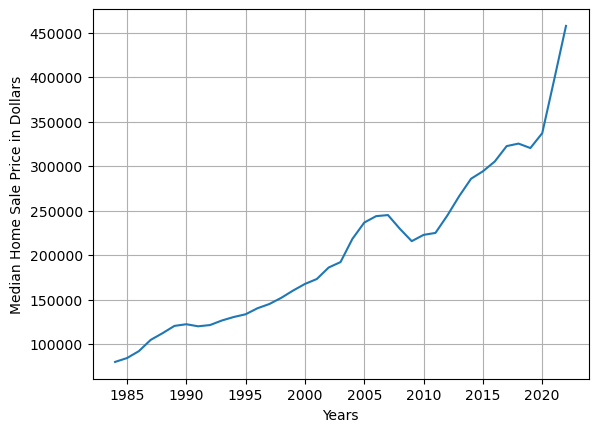

In [62]:
x_axis_data = Median_HomeSales_Dollars["DATE"]
y_axis_data = Median_HomeSales_Dollars["Median Home Sales in Dollars"]
plt.plot(x_axis_data, y_axis_data)
plt.xlabel("Years")
plt.ylabel("Median Home Sale Price in Dollars")
plt.grid()
plt.savefig("Images/MedianHomeSalePrice_dt.png")
plt.show()

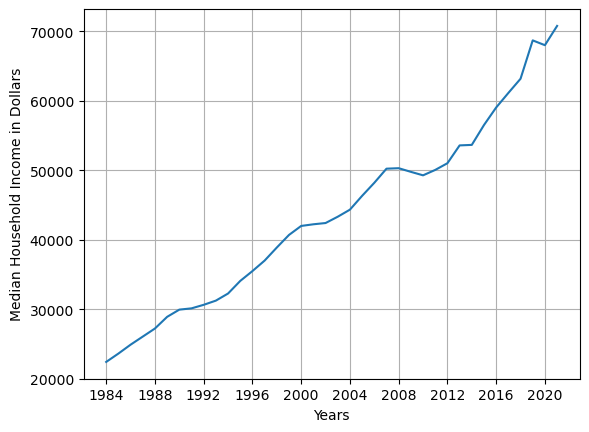

In [63]:
x_axis_data = Median_Income_Dollars["DATE"]
y_axis_data = Median_Income_Dollars["Median Income in Dollars"]
plt.plot(x_axis_data, y_axis_data)
plt.xlabel("Years")
plt.ylabel("Median Household Income in Dollars")
plt.grid()
plt.savefig("Images/MedianHouseHoldIncome_dt.png")
plt.show()

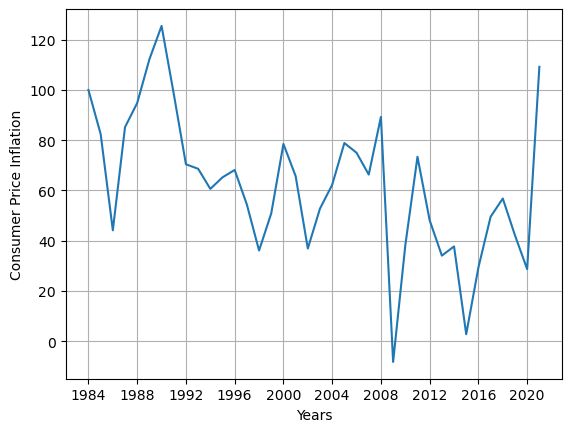

In [64]:
x_axis_data = final_data2_df["DATE"]
y_axis_data = final_data2_df["Consumer_Price_Inflation"]
plt.plot(x_axis_data, y_axis_data)
plt.grid()
plt.xlabel("Years")
plt.ylabel("Consumer Price Inflation")
plt.savefig("Images/ConsumerPriceInflation_dt.png")
plt.show()

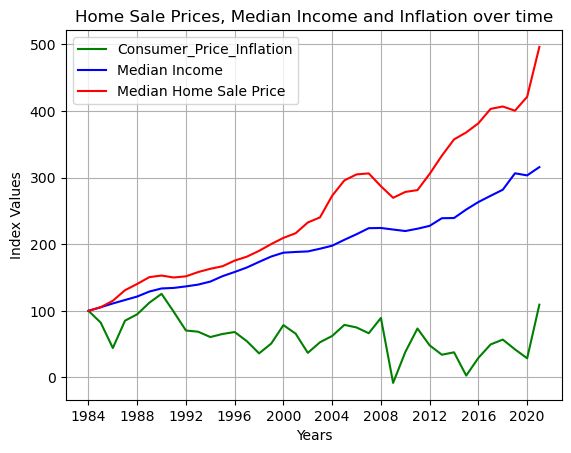

In [65]:
Date = final_data2_df["DATE"]
InflationAxis = final_data2_df["Consumer_Price_Inflation"]
MedianIncomeAxis = final_data2_df["Median_Household_Income"]
MedianHomeAxis = final_data2_df["Median_Home_Sale_Price"]

plt.plot(Date, InflationAxis, color = "green", label = "Consumer_Price_Inflation")
plt.plot(Date, MedianIncomeAxis, color = "blue", label = "Median Income")
plt.plot(Date, MedianHomeAxis, color = "red", label = "Median Home Sale Price")
plt.title("Home Sale Prices, Median Income and Inflation over time")
plt.xlabel("Years")
plt.ylabel("Index Values")
plt.legend(loc = "best")
plt.grid()
plt.savefig("Images/FinalCompare_dt.png")
plt.show()